# Kepler Scatter

Import rebound and add in the center body

In [1]:
import rebound
import numpy as np
sim = rebound.Simulation()
sim.add(m=1., r=0.005)

For definition of the orbit elements, refer to  https://en.wikipedia.org/wiki/Kepler_orbit

We can add the bodies in by hand fairly easy. 
Mass are all in solar mass, radius and distance in AU, and angles in rad. 

In [2]:
sim.add(m=0.5e-3, r=0.0005,a=0.2, e=7.e-3, inc=0.,Omega=142*0.0174,omega=302.38*0.0174,M=6.1*0.0174,id=1)
sim.add(m=0.5e-3, r=0.0005,a=0.22, e=7.e-3, inc=0.,Omega=142*0.0174,omega=302.38*0.0174,M=4*0.0174,id=2)
#sim.add(m=1e-3, r=0.0005,a=3.3, e=1.15e-2, inc=0.2*0.0174,Omega=139*0.0174,omega=174*0.0174,M=320*0.0174,id=2)
#sim.add(m=1e-3, r=0.0005,a=4.3, e=7.e-3, inc=0.13*0.0174,Omega=140*0.0174,omega=177*0.0174,M=157*0.0174,id=3)
#sim.add(m=4.8e-5, r=0.0001,a=0.97, e=2.6e-2, inc=0.47*0.0174,Omega=239*0.0174,omega=124*0.0174,M=172*0.0174,id=4)
#sim.add(m=4.8e-5,r=0.0001, a=0.2, e=1.2e-2, inc=0.52*0.0174,Omega=124*0.0174,omega=92*0.0174,M=263*0.0174,id=5)
#sim.add(m=4.8e-5,r=0.0001, a=0.39, e=2.e-2, inc=0.5*0.0174,Omega=294*0.0174,omega=187*0.0174,M=292*0.0174,id=6)

In practice example, we want to have an initial condition array, so that we can save them and explore later. 

In [3]:
def orbit2str(particle):
    orbit=particle.orbit
    string="%15.12f %15.12f %15.12f %15.12f %15.12f %15.12f %15.12f %15.12f"%(particle.m,particle.r,orbit.a,orbit.e,orbit.inc,orbit.Omega,orbit.omega,orbit.f)
    return string

init=[]
for p in sim.particles:
    if p.id==0:
        continue
    parr=np.array(list(orbit2str(p).split()),dtype='f8')
    init.append(parr)
print init

[array([  5.00000000e-04,   5.00000000e-04,   2.00000000e-01,
         7.00000000e-03,   0.00000000e+00,   0.00000000e+00,
         1.44902669e+00,   1.07636184e-01]), array([  5.00000000e-04,   5.00000000e-04,   2.20000000e-01,
         7.00000000e-03,   0.00000000e+00,   0.00000000e+00,
         1.44902669e+00,   7.05821836e-02])]


To plot these initial orbits in the xy-plane, we can simply call the OrbitPlot function and give it the simulation as an argument.

/Users/chelsea/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


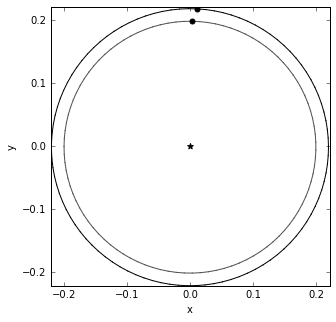

In [4]:
%matplotlib inline
fig = rebound.OrbitPlot(sim)

In [5]:
#set up integrator
sim.integrator="ias15" 
#sim.integrator="hybrid"
sim.ri_hybarid.switch_ratio = 10  #units of Hill radii
sim.ri_hybarid.CE_radius = 15.  #X*radius
sim.testparticle_type = 1

#set up time step    
sim.dt = 0.001 #time step in units of yr/2pi
tmax = 1e3*6.2832 #time in units of yr/2pi
Noutputs=100
#set up collision options
#by default, the end result of the collision always 
#keep the small id number.
sim.collision="direct"
sim.collision_resolve = "merge"
sim.collisions_track_dE = 1

#set up escape options
sim.exit_max_distance = 50.
#sim.exit_min_distance = 0.01
#print sim.collisions[0]

Sometimes we would like to examine what's in sim

In [6]:
def lookup(boo):
    import inspect
    print inspect.getmembers(boo, predicate=inspect.ismethod)
    print inspect.getmembers(boo,lambda a:not(inspect.isroutine(a)))
#lookup(sim)
#lookup(rebound)

Before we do the integration, let's first define some status code for specific situations we run into in the simulation. 

In [7]:
statuscode={"eject":2,"star":3,"collision":1,"survive":0}

We also want to define an output function to save some intermediate result.

In [8]:
def saveorbit(outfile,sim):
    fout=open(outfile,mode="a")
    for p in sim.particles:
        if p.id==0:
            continue
        line=orbit2str(p)
        fout.write("%f %d %s\n" % (sim.t,p.id,line))
    fout.close()
    return

Now we are at the main integration loop. Let's initialize a bunch of stuff first. 

In [9]:
times = np.linspace(0,tmax,Noutputs)
Ncurrent = sim.N
finalstatus=np.zeros(Ncurrent-1)
nstep=np.zeros(Ncurrent-1)
end=np.zeros([Ncurrent-1,8])
outfile="testoutput.txt"
fout=open(outfile,"w")
fout.close()

In the main loop, we integrate the required time length till an output checkpoint, except in our case we need to catch:
- the ejected particles;
- the particles collided with another body

We also want to:
- update the endresult array;
- write to an output file. 

TBD: 
This can be write into a nicer way with steps splited into individual functions. 

In [10]:
for i,time in enumerate(times):
    try:
        sim.integrate(time)   
    #deal with Escape
    except rebound.Escape as error:
        
        #print error
        max_d2 = 0.
        peject=None
        for p in sim.particles:
            if p.id==0:
                continue
            d2 = p.x*p.x + p.y*p.y + p.z*p.z
            if d2>max_d2:
                max_d2 = d2
                mid = p.id
                peject=p
        end[mid-1,:]=np.array(list(orbit2str(peject).split()),dtype='f8')
        sim.remove(id=mid)
        nstep[mid-1]=int(sim.t/sim.dt)
        Ncurrent-=1
        finalstatus[mid-1]=statuscode['eject']
        #print "final status",mid,"eject"
    #deal with collision
    if Ncurrent>sim.N:
        #print "collision"
        for i in xrange(len(finalstatus)):
            
            if finalstatus[i]==0:
                cflag=True
                for p in sim.particles:
                    #print p,i+1,cflag
                    if p.id==0:
                        continue
                    if (p.id)==(i+1):
                        cflag=False
                        break
                #print i,cflag
                if cflag:
                    finalstatus[i]=statuscode['collision']
                    nstep[i]=int(sim.t/sim.dt)
                    #print "final status",i+1,'collision'
        Ncurrent=sim.N
    #print orbit2str(sim.particles[1].orbit)
    for p in sim.particles:
        if p.id==0:
            continue
        end[p.id-1,:]=np.array(list(orbit2str(p).split()),dtype='f8')
    if not outfile is None:
        
        saveorbit(outfile,sim)
#TBD:how to handel the collision with star


Now we finished our integration, last step would be write a summary file 
of all the information we collected about this run. 

I will use the pickle module here so that the information is stored in 
a way only python understands. I will demonstrate how to use these information in another plot demo. 

In [11]:
import pickle
#total number of planets left
npcount=len(sim.particles)-1
#total number of earth type planet left
necount=0
for p in sim.particles:
    if p.id==0:
        continue
    if p.m<0.5e-3:
        necount+=1
    nstep[p.id-1]=int(sim.t/sim.dt)
    
print init
print end
print nstep
print finalstatus
print npcount
print necount
datadump=[init,end,nstep,finalstatus,npcount,necount]
infofile="info.pkl"
def write_outcome(infofile,datadump):
    pickle.dump(datadump,open(infofile,"w"))
    return

[array([  5.00000000e-04,   5.00000000e-04,   2.00000000e-01,
         7.00000000e-03,   0.00000000e+00,   0.00000000e+00,
         1.44902669e+00,   1.07636184e-01]), array([  5.00000000e-04,   5.00000000e-04,   2.20000000e-01,
         7.00000000e-03,   0.00000000e+00,   0.00000000e+00,
         1.44902669e+00,   7.05821836e-02])]
[[  1.00000000e-03   6.29960525e-04   2.09750356e-01   1.01422505e-02
    0.00000000e+00   0.00000000e+00   1.31650754e+00   1.40189660e+00]
 [  5.00000000e-04   5.00000000e-04   2.20000000e-01   7.00000000e-03
    0.00000000e+00   0.00000000e+00   1.44902669e+00   7.05821836e-02]]
[ 451728.    4263.]
[ 0.  1.]
1
0


Let's just look at the result of the current run with OrbitPlot. 

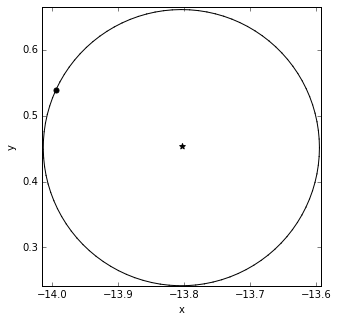

In [12]:
#?rebound.OrbitPlot
fig = rebound.OrbitPlot(sim)

In [13]:
#sim.status()
for o in sim.calculate_orbits():
    print o
for i in sim.particles:
    print i

<rebound.Orbit instance, a=0.209750355568 e=0.0101422504782 inc=0.0 Omega=0.0 omega=1.31650753918 f=1.40189660315>
<rebound.Particle object, id=0 m=1.0 x=-13.8036259148 y=0.453582493941 z=0.0 vx=-0.00127923185856 vy=0.00205656943937 vz=0.0>
<rebound.Particle object, id=1 m=0.001 x=-13.9945278254 y=0.539565172507 z=0.0 vx=-0.919906707083 vy=-1.98432701089 vz=0.0>
